# Trabalho 1 - Séries Temporais

EELT7016 - Séries Temporais

Autores:

- Ana Paula da Silva Pelegrini GRR20177221
- Caio Phillipe Mizerkowski GRR20166403

Código:

[GitHub](https://github.com/CaioMizerkowski/mestrado/blob/master/EELT7016/trabalho_01.ipynb)


# Introdução

No primeiro trabalho da disciplina de mestrado EELT7016 foram utilizadas duas séries temporais, o preço médio da [Batata Agata](https://www.hfbrasil.org.br/br/estatistica/batata.aspx) durante o período de 2008 a 2022 e o preço médio do [Leite](https://cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx) entre 2012 e 2022. Para se realizar a previsão destas séries temporais foram utilizados dois modelos: O modelo AR (autoregresivo) e o modelo ARMA (autoregresivo com média móvel).

Foram usadas 70% das amostras para o treinamento dos modelos de 30% das amostras para a validação dos mesmos.

As principais bibliotecas utilizadas neste trabalho foram: Polars, Numpy, Matplolib, Seaborn, Scipy e Statsmodels. Um algoritmo de minímos quadrados em batelada, escrita durante a disciplina TE975, foi utilizado para o modelo AR e a classe SARIMAX da biblioteca statsmodels foi utilizada para o modelo ARMA.


# Imports e globais


In [1]:
import warnings
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import batelada as bt
import scipy as sp
import statsmodels.api as sm
from itertools import product
from typing import NamedTuple
from collections import defaultdict
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

figsize = (10, 5)

arma_keys = {
    "ar.L1",
    "ar.L2",
    "ar.L3",
    "ar.L4",
    "ma.L1",
    "ma.L2",
    "ma.L3",
    "ma.L4",
    "sigma2",
}

ar_keys = {
    "ar.L1",
    "ar.L2",
    "ar.L3",
    "ar.L4",
}


# Funções


Para a análise da normalidade dos resíduos, foram escolhidos os seguintes testes:

- D'Agostino's K-squared
- Kolmogorov-Smirnov
- Lilliefors
- Shapiro-Wilk

Eles foram escolhidos a partir do [material de referência](https://towardsdatascience.com/methods-for-normality-test-with-application-in-python-bb91b49ed0f5) apresentado pelo professor durante as aulas.


In [2]:
def testes_normalidade(resid):
    print(f"D'Agostino's K-squared test: {sp.stats.normaltest(resid)}\n")
    print(f"Kolmogorov-Smirnov test: {sp.stats.kstest(resid, 'norm')}\n")
    print(
        f"Lilliefors test: {sm.stats.diagnostic.lilliefors(resid, dist='norm', pvalmethod='table')}\n"
    )
    print(f"Shapiro-Wilk test: {sp.stats.shapiro(resid)}\n")


As funções plot_resid, ked_resid e plot_serie foram usadas para a visualização dos resultados.


In [3]:
def plot_resid(t, resid, title):
    plt.figure(figsize=figsize)
    sns.lineplot(x=t, y=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Erro")
    plt.grid()
    plt.show()
    plt.close()


In [4]:
def ked_resid(resid, title):
    plt.figure(figsize=figsize)
    sns.kdeplot(x=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(
        f"""{title}
    Média: {(resid).mean():.3}
    Desvio padrão: {(resid).std():.3}"""
    )
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Erro")
    plt.ylabel("KDE")
    plt.grid()
    plt.show()
    plt.close()


In [5]:
def plot_serie(t, y, yest, title):
    plt.figure(figsize=figsize)
    sns.scatterplot(x=t, y=y, color="green", markers=".", label="Pontos medidos")
    sns.lineplot(x=t, y=yest, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Real", "Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Saída")
    plt.grid()
    plt.show()
    plt.close()


In [6]:
def plots_metricas_arma(resid, t, y, yest, ar, ma, mse):
    print(f"Modelo ar:{ar} ma:{ma} com mse: {mse:.3}\n")

    title = f"Desempenho"
    plot_serie(t, y, yest, title)

    title = f"Residuos"
    plot_resid(t, resid, title)

    title = f"Distribuição dos residuos"
    ked_resid(resid, title)


In [7]:
def plots_metricas_ar(resid, t, y, yest, na, nb, mse):
    print(f"Modelo na:{na} com mse: {mse:.3}\n")

    title = f"Desempenho"
    plot_serie(t, y, yest, title)

    title = f"Residuos"
    plot_resid(t, resid, title)

    title = f"Distribuição dos residuos"
    ked_resid(resid, title)


Os resultados foram gerados pelas funções train_arma e train_ar, aplicando respectivamente o modelo ARMA e o AR.


In [8]:
class ModelResult(NamedTuple):
    resid: np.array
    mse_train: float
    mse_test: float
    params: dict
    yest: np.array


In [9]:
def train_arma(y, train, ar, ma):
    deep = max(ar, ma)
    npts = y.size
    train_size = round(train * len(y))

    arma = SARIMAX(endog=y[:train_size], order=(ar, 0, ma)).fit(disp=False)
    params = dict(zip(arma.param_names, arma.params))
    arma = arma.append(endog=y[train_size:], refit=False)
    yest = arma.predict(0, len(y) - 1)

    resid = y - yest
    mse_train = np.sum((y[:train_size] - yest[:train_size]) ** 2) / (train_size)
    mse_test = np.sum((y[train_size:] - yest[train_size:]) ** 2) / (npts - train_size)
    return ModelResult(resid, mse_train, mse_test, params, yest)


In [10]:
def train_ar(u, y, train, na, nb):
    deep = max(na, nb)
    npts = y.size
    delay = 0
    train_size = round(train * len(y))

    yest, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
    params = {f"ar.L{i+1}": t for i, t in enumerate(theta)}

    resid = y - yest
    mse_train = np.sum((y[:train_size] - yest[:train_size]) ** 2) / (train_size - deep)
    mse_test = np.sum((y[train_size:] - yest[train_size:]) ** 2) / (
        npts - deep - train_size
    )
    return ModelResult(resid, mse_train, mse_test, params, yest)


As iterações pelos valores de ar, ma e na foram realizadas pelas funções run_arma e run_ar. No qual os valores foram salvos em um dataframe do polars para a visualização e o melhor conjunto de parâmetros para cada caso foi selecionado pelo MSE de validação.


In [11]:
def run_arma(y, train):
    mse_low = np.Inf
    best = (0, 0)
    params_total = defaultdict(list)

    for ar, ma in product(range(1, 5), range(1, 5)):
        _, mse_train, mse_test, params, _ = train_arma(y, train, ar, ma)

        params_total["ar"].append(ar)
        params_total["ma"].append(ma)

        for key, value in params.items():
            params_total[key].append(value)

        for key in arma_keys - params.keys():
            params_total[key].append(None)

        params_total["mse.train"].append(mse_train)
        params_total["mse.test"].append(mse_test)

        if mse_low > mse_test:
            best = (ar, ma)
            mse_low = mse_test

    return best, params_total


In [12]:
def run_ar(u, y, train):
    mse_low = np.Inf
    best = 0
    params_total = defaultdict(list)

    for na in range(1, 5):
        _, mse_train, mse_test, params, _ = train_ar(u, y, train, na, 0)
        params_total["na"].append(na)
        if mse_low > mse_test:
            best = na
            mse_low = mse_test

        for key, value in params.items():
            params_total[key].append(value)

        for key in ar_keys - params.keys():
            params_total[key].append(None)

        params_total["mse.train"].append(mse_train)
        params_total["mse.test"].append(mse_test)
    return best, params_total


# Batata


## Pré-processamento


In [13]:
df_batata = pd.read_excel("20221001214857-precos-medios-batata.xlsx")
df_batata = pl.DataFrame(df_batata)
date_batata = df_batata.select(
    pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=pl.col("Dia")).alias("Data")
)
df_batata = df_batata.with_column(date_batata.to_series())


Para os dados da batata agata, em razão da falta de periodizidade da amostragem, foi realizada uma média mensal do valor do produto e nos meses sem dados foi realizada uma interpolação linear para a geração de dados.


In [14]:
df_agata = df_batata.filter(
    (pl.col("Produto") == "Padrão agata primeira - beneficiador")
    & (pl.col("Unidade") == "saco 50 kg")
    & (pl.col("Data").is_between(pl.datetime(2008, 1, 1), pl.datetime(2020, 12, 31)))
).select(["Data", "Preço", "Ano", "Mês"])


df_agata = (
    df_agata.groupby(["Ano", "Mês"])
    .agg(
        [
            pl.col("Preço").mean().alias("Preço médio"),
            pl.col("Preço").std().alias("Preço desvio"),
            pl.col("Preço").min().alias("Preço menor"),
            pl.col("Preço").max().alias("Preço maior"),
        ]
    )
    .select(
        [
            pl.all(),
            pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=1).alias("Data"),
        ]
    )
    .sort("Data")
)

df_agata = df_agata.upsample("Data", "1mo").interpolate().fill_null("forward")


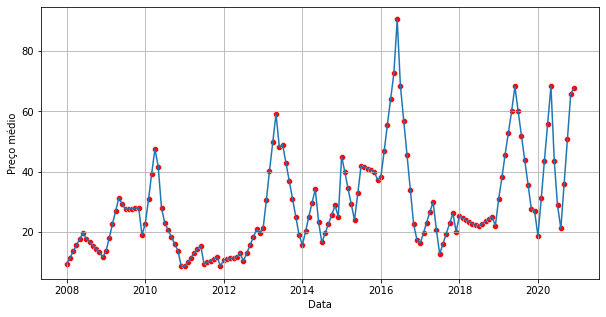

In [15]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_agata.to_pandas(), x="Data", y="Preço médio")
sns.scatterplot(data=df_agata.to_pandas(), x="Data", y="Preço médio", color="red")
plt.grid()
plt.show()
plt.close()


## Carregar dados


In [16]:
data = df_agata.select(["Mês", "Preço médio"]).to_numpy()

u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")
train, t = 0.7, np.arange(len(y))


Número de pontos: 156


## Modelo AR


O melhor modelo AR encontrado, varrendo o parâmetro $n_a$ entre 1 e 4, foi o modelo com $n_a$ igual a 4. Com um MSE de treinamento de 0.233.

Modelo na:4 com mse: 0.233



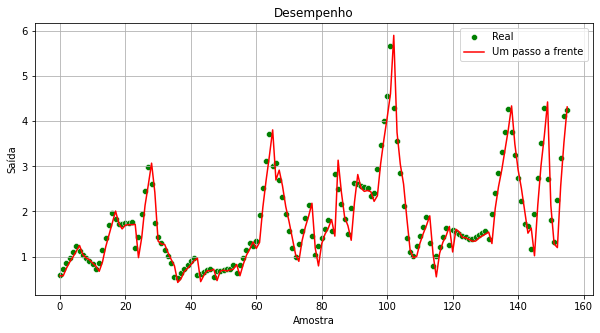

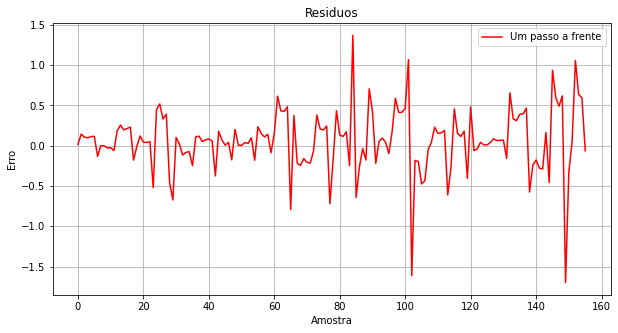

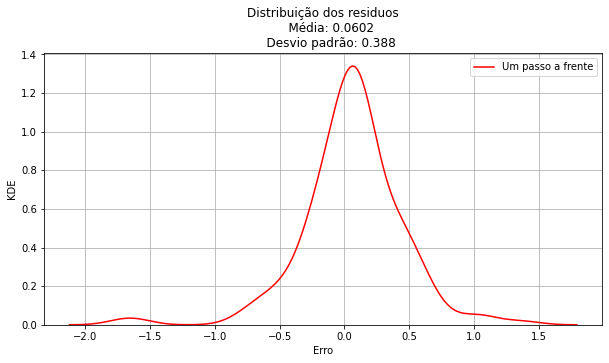

In [17]:
na, params_total = run_ar(u, y, train)
resid, mse_train, mse_test, params, yest = train_ar(u, y, train, na, 0)
plots_metricas_ar(resid, t, y, yest, na, 0, mse_test)


A tabela com os diferentes parâmetros do modelo autoregressivo e o MSE para teste e validação está presente a seguir.

In [18]:
summarized_results = pl.DataFrame(params_total)
summarized_results[["na"] + sorted(list(ar_keys)) + ["mse.train", "mse.test"]]


na,ar.L1,ar.L2,ar.L3,ar.L4,mse.train,mse.test
i64,f64,f64,f64,f64,f64,f64
1,-0.980899,null,null,null,0.148986,0.281165
2,-1.320345,0.346722,null,null,0.132342,0.23448
3,-1.304422,0.285922,0.046189,null,0.133308,0.243755
4,-1.30853,0.263115,0.155211,-0.084797,0.133649,0.232583


Os testes de normalidade, cuja hipotese nula é que a distribuição é normal, apresentaram um pvalue próximo a zero, rejeitando a hipotese nula.

In [19]:
testes_normalidade(resid)


D'Agostino's K-squared test: NormaltestResult(statistic=35.112953318303134, pvalue=2.3731165345961686e-08)

Kolmogorov-Smirnov test: KstestResult(statistic=0.2829356297064548, pvalue=1.5292943903255566e-11)

Lilliefors test: (0.09828979341008348, 0.0020793904212572994)

Shapiro-Wilk test: ShapiroResult(statistic=0.9234163165092468, pvalue=2.264215339664588e-07)



## Modelo ARMA


O melhor modelo ARMA encontrado, varrendo os parâmetros $ar$ e $ma$ entre 1 e 4, foi o modelo com $ar$ igual a 4 e $ma$ igual a 4. Com um MSE de treinamento de 0.189.

Modelo ar:4 ma:4 com mse: 0.189



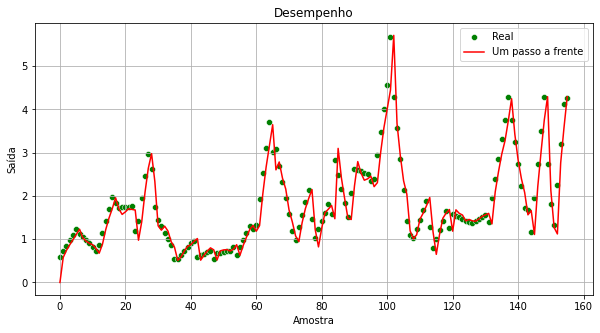

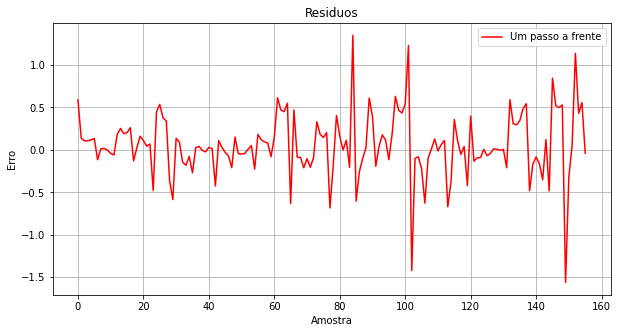

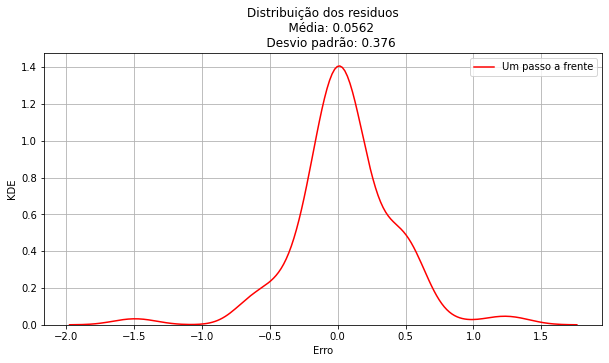

In [20]:
(ar, ma), params_total = run_arma(y, train)
resid, mse_train, mse_test, params, yest = train_arma(y, train, ar, ma)
plots_metricas_arma(resid, t, y, yest, ar, ma, mse_test)


A tabela com os diferentes parâmetros do modelo ARMA e o MSE para teste e validação está presente a seguir.

In [21]:
summarized_results = pl.DataFrame(params_total)
summarized_results[["ar", "ma"] + sorted(list(arma_keys)) + ["mse.train", "mse.test"]]


ar,ma,ar.L1,ar.L2,ar.L3,ar.L4,ma.L1,ma.L2,ma.L3,ma.L4,sigma2,mse.train,mse.test
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,1,0.964103,null,null,null,0.294636,null,null,null,0.133159,0.136228,0.231808
1,2,0.954987,null,null,null,0.314313,0.185875,null,null,0.129583,0.132668,0.219078
1,3,0.943573,null,null,null,0.365154,0.24325,0.11453,null,0.128005,0.131102,0.221187
1,4,0.959113,null,null,null,0.325507,0.193964,0.037165,-0.122746,0.126576,0.129676,0.205266
2,1,1.38468,-0.413745,null,null,-0.083965,null,null,null,0.129901,0.132987,0.228264
2,2,1.185353,-0.224705,null,null,0.10175,0.141754,null,null,0.128933,0.132024,0.221116
2,3,1.844939,-0.845096,null,null,-0.629935,-0.117766,-0.221345,null,0.125364,0.128747,0.199539
2,4,1.73961,-0.740024,null,null,-0.483704,-0.098796,-0.153621,-0.193616,0.1216,0.124889,0.190273
3,1,1.072414,0.016206,-0.127639,null,0.219911,null,null,null,0.12968,0.132767,0.227911


Os testes de normalidade, cuja hipotese nula é que a distribuição é normal, apresentaram um pvalue próximo a zero, rejeitando a hipotese nula.

In [22]:
testes_normalidade(resid)


D'Agostino's K-squared test: NormaltestResult(statistic=22.891524730823342, pvalue=1.0694698940182447e-05)

Kolmogorov-Smirnov test: KstestResult(statistic=0.2884199264027345, pvalue=5.525475538763243e-12)

Lilliefors test: (0.11038506285483685, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.9283058047294617, pvalue=4.904987918052939e-07)



# Leite


## Pré-processamento


In [19]:
df_leite = pd.read_excel("cepea-consulta-20221001213951-leite.xls")
df_leite = pl.DataFrame(df_leite)
columns = df_leite.columns[1:]
columns = [
    df_leite[c].str.replace(",", ".").str.replace("-", "NaN").apply(float).alias(c)
    for c in columns
]
df_leite = df_leite.with_columns(columns)
df_leite = df_leite.with_column(
    ("01/" + pl.col("Data")).str.strptime(pl.Date, fmt="%d/%m/%Y").alias("Data")
)
df_leite = df_leite.select(
    [pl.col("Data"), pl.col("Preço líquido médio").alias("Preço")]
)


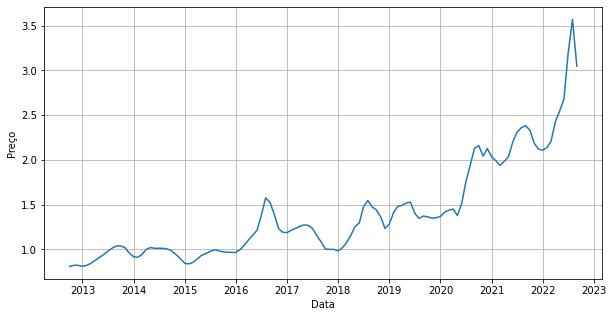

In [20]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_leite.to_pandas(), x="Data", y="Preço")
plt.grid()
plt.show()
plt.close()


## Carregar Dados


In [21]:
data = df_leite.select([pl.col("Data").dt.month(), "Preço"]).to_numpy()

print("Método dos mínimos quadrados em batelada")
u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo de LS precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")
train, t = 0.7, np.arange(len(y))


Método dos mínimos quadrados em batelada
Número de pontos: 120


## Modelo AR


O melhor modelo AR encontrado, varrendo o parâmetro $n_a$ entre 1 e 4, foi o modelo com $n_a$ igual a 3. Com um MSE de treinamento de 0.0844.

Modelo na:3 com mse: 0.0844



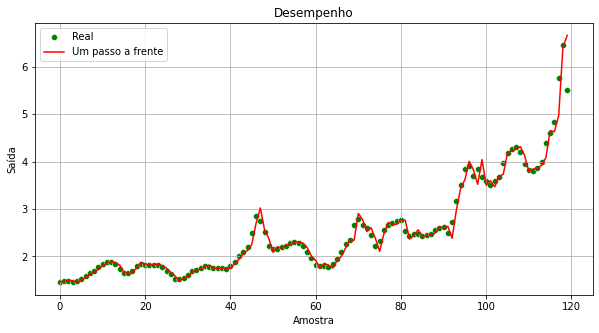

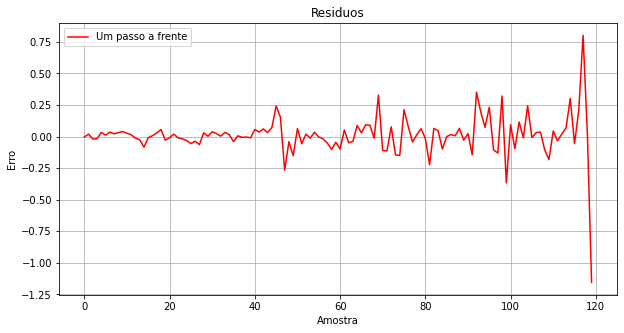

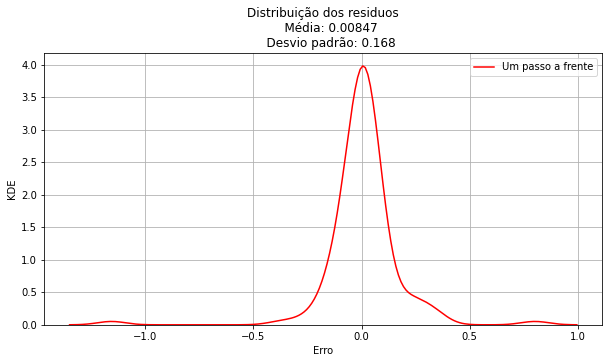

In [26]:
na, params_total = run_ar(u, y, train)
resid, mse_train, mse_test, params, yest = train_ar(u, y, train, na, 0)
plots_metricas_ar(resid, t, y, yest, na, 0, mse_test)


A tabela com os diferentes parâmetros do modelo autoregressivo e o MSE para teste e validação está presente a seguir.

In [27]:
summarized_results = pl.DataFrame(params_total)
summarized_results[["na"] + sorted(list(ar_keys)) + ["mse.train", "mse.test"]]


na,ar.L1,ar.L2,ar.L3,ar.L4,mse.train,mse.test
i64,f64,f64,f64,f64,f64,f64
1,-1.004318,null,null,null,0.012082,0.09371
2,-1.574555,0.574191,null,null,0.008246,0.093078
3,-1.782401,1.143006,-0.362935,null,0.007297,0.084404
4,-1.784107,1.148614,-0.37206,0.005257,0.007388,0.086939


Os testes de normalidade, cuja hipotese nula é que a distribuição é normal, apresentaram um pvalue próximo a zero, rejeitando a hipotese nula.

In [28]:
testes_normalidade(resid)


D'Agostino's K-squared test: NormaltestResult(statistic=85.62831105293031, pvalue=2.5471147307328913e-19)

Kolmogorov-Smirnov test: KstestResult(statistic=0.3982507447339736, pvalue=1.10698485679656e-17)

Lilliefors test: (0.19856571770420084, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.7028815746307373, pvalue=2.9050421329569406e-14)



## Modelo ARMA


O melhor modelo ARMA encontrado, varrendo os parâmetros $ar$ e $ma$ entre 1 e 4, foi o modelo com $ar$ igual a 2 e $ma$ igual a 3. Com um MSE de treinamento de 0.0713.

Modelo ar:2 ma:3 com mse: 0.0713



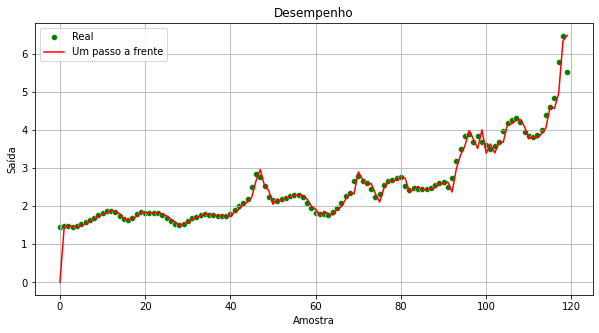

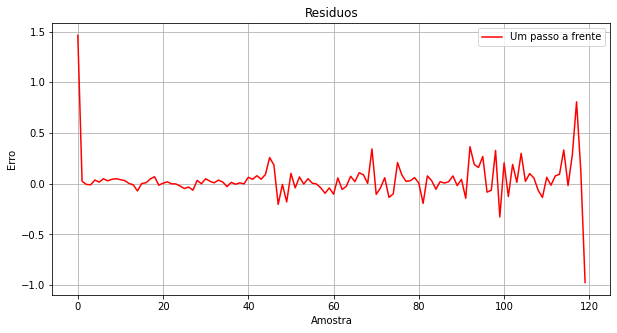

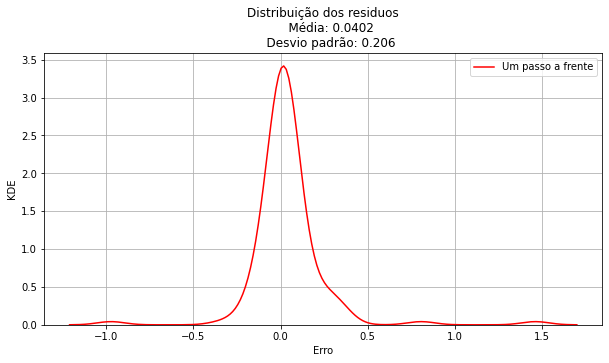

In [29]:
(ar, ma), params_total = run_arma(y, train)
resid, mse_train, mse_test, params, yest = train_arma(y, train, ar, ma)
plots_metricas_arma(resid, t, y, yest, ar, ma, mse_test)


A tabela com os diferentes parâmetros do modelo ARMA e o MSE para teste e validação está presente a seguir.

In [30]:
summarized_results = pl.DataFrame(params_total)
summarized_results[["ar", "ma"] + sorted(list(arma_keys)) + ["mse.train", "mse.test"]]


ar,ma,ar.L1,ar.L2,ar.L3,ar.L4,ma.L1,ma.L2,ma.L3,ma.L4,sigma2,mse.train,mse.test
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,1,0.99752,null,null,null,0.675955,null,null,null,0.00737,0.032789,0.07454
1,2,0.996638,null,null,null,0.812123,0.189682,null,null,0.007079,0.032502,0.074604
1,3,0.996552,null,null,null,0.813457,0.201261,0.013734,null,0.007078,0.032501,0.075109
1,4,0.995894,null,null,null,0.831638,0.24021,0.079966,0.056002,0.007068,0.032489,0.075245
2,1,0.317605,0.679463,null,null,0.999121,null,null,null,0.010177,0.035765,0.121716
2,2,1.883379,-0.883462,null,null,-0.253678,-0.643296,null,null,0.007279,0.032696,0.073979
2,3,1.791155,-0.791345,null,null,-0.029399,-0.549476,-0.224928,null,0.00688,0.032294,0.071301
2,4,0.187848,0.80101,null,null,1.638231,0.913854,0.253203,0.073621,0.007129,0.032487,0.073672
3,1,0.639244,0.854726,-0.498336,null,0.995751,null,null,null,0.00777,0.033264,0.096724


Os testes de normalidade, cuja hipotese nula é que a distribuição é normal, apresentaram um pvalue próximo a zero, rejeitando a hipotese nula.

In [31]:
testes_normalidade(resid)


D'Agostino's K-squared test: NormaltestResult(statistic=98.12096510533327, pvalue=4.935181711609342e-22)

Kolmogorov-Smirnov test: KstestResult(statistic=0.4026479956286596, pvalue=4.428999184990594e-18)

Lilliefors test: (0.23154646129727408, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.6465409994125366, pvalue=1.379936843876647e-15)



# Resultados

1) Tabelas presentes junto a cada modelo no decorrer do código.

2) a) Para os dados do preço da batata o melhor modelo foi o ARMA (ar=4, ma=4) com mse de treinamento igual a 0.189.

   b) Para os dados do preço do leite o melhor modelo foi o ARMA (ar=2, ma=3) com mse de validação igual a 0.0713.

3) O melhor modelo foi escolhido baseado no MSE de validação, o MSE de estimação também está presente em todas as tabelas geradas.

4) Análises presentes junto a cada modelo no decorrer do código.